In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
runner = pd.read_csv("../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

In [3]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    country_to_predict = race_to_predict.iloc[0]['country_code']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        total_races = 0
        avg_relative_rank = 1
        avg_rank = 10000
        max_relative_rank = 1
        min_relative_rank = 1
        
        total_elevation = 0
        avg_elevation = 0
        
        total_distance = 0
        avg_distance = 0
        min_distance = 0
        max_distance = 0
        
        total_eq_distance = 0
        avg_eq_distance = 0
        min_eq_distance = 0
        max_eq_distance = 0
        
        avg_runners = 0
        
        years_of_activity = race_to_predict.year
        last_year_activity = race_to_predict.year
        
        
        
        
        has_run = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        avg_speed = 0
        last_course_speed = 0
        home_country = 0
        avg_speed = 0
        avg_equivalent_speed = 0
        
        if nationality == country_to_predict:
            home_country = 1
        
        if runner_past.size >= 1: 
            has_run = 1
            total_races = runner_past.shape[0]
            
            avg_relative_rank = runner_past.relative_ranking.mean()
            avg_rank = runner_past.ranking.mean()
            max_relative_rank = runner_past.relative_ranking.max()
            min_relative_rank = runner_past.relative_ranking.min()
            
            total_elevation = runner_past.elevation_gain.sum()
            avg_elevation = runner_past.elevation_gain.mean()
            
            total_distance =  runner_past.distance.sum()
            avg_distance = runner_past.distance.mean()
            min_distance = runner_past.distance.min()
            max_distance = runner_past.distance.max()
            
            total_eq_distance = runner_past.equivalent_distance.sum()
            avg_eq_distance = runner_past.equivalent_distance.mean()
            min_eq_distance = runner_past.equivalent_distance.min()
            max_eq_distance = runner_past.equivalent_distance.max()
            
            avg_runners = runner_past.frequency_in_ranking.mean()

            avg_speed = runner_past.equivalent_speed.mean()
            last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']
            
            years_of_activity = race_to_predict.year - runner_past.year.min()
            
            last_year_activity = runner_past.year.max()
            
            
            avg_speed = runner_past.speed.mean()
            avg_equivalent_speed = runner_past.equivalent_speed.mean()
            
            
#             for i in range(len(runner_past)):
#                 ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'n_races': total_races,
                        'avg_relative_rank': avg_relative_rank,
                        'avg_rank': avg_rank,
                        'max_relative_rank' : max_relative_rank,
                        'min_relative_rank' : min_relative_rank,
                        'total_elevation' : total_elevation,
                        'avg_elevation' : avg_elevation,
                        'total_distance' : total_distance,
                        'avg_distance' : avg_distance,
                        'min_distance' : min_distance,
                        'max_distance' : max_distance,
                        'total_eq_distance' : total_eq_distance,
                        'avg_eq_distance' : avg_eq_distance,
                        'min_eq_distance' : min_eq_distance,
                        'max_eq_distance' : max_eq_distance,
                        'avg_runners' : avg_runners,
                        'years_of_activity': years_of_activity,
                        'last_year_activity': last_year_activity,
                        'avg_speed': avg_speed,
                        'avg_equivalent_speed': avg_equivalent_speed,
                        
                        'total_distance': total_distance,
#                         'distance_previous_year': distance_previous_year,
                        'has_run': has_run,
#                         'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
#                         'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                        'last_course_speed': last_course_speed,
                        'home_country': home_country
                       }, ignore_index = True)
        
        
    values_to_predict = join.loc[join.race_year_id == race_year_id_to_predict][['runner_id','ranking','relative_ranking','time_in_seconds']]
    values_to_predict = values_to_predict.drop_duplicates(subset=['runner_id'], keep='last')
    values_to_predict = values_to_predict.reset_index()
    
    one_hot_gender = pd.get_dummies(df['gender'], prefix = "gender")
    one_hot_nationality= pd.get_dummies(df['nationality'], prefix = "nat")
    # Drop column B as it is now encoded
    df = df.drop('gender',axis = 1)
    df = df.drop('nationality',axis = 1)
    # Join the encoded df
    df = df.join(one_hot_gender)
    df = df.join(one_hot_nationality)
    
    return df, values_to_predict

In [4]:
runner_p, dz = runner_profile(join,race, 39881)

100%|██████████████████████████████████████████████████████████████████████████████| 1557/1557 [00:31<00:00, 49.78it/s]


In [5]:
runner_p

,runner_id,age,n_races,avg_relative_rank,avg_rank,max_relative_rank,min_relative_rank,total_elevation,avg_elevation,total_distance,...,nat_SRB,nat_SUI,nat_SVK,nat_SWE,nat_THA,nat_TPE,nat_TUR,nat_UKR,nat_USA,nat_VEN
0,CAPELLPauESPM30.0,30.0,3.0,0.002780,3.000000,0.004630,0.001351,24780.0,8260.000000,494.0,...,0,0,0,0,0,0,0,0,0,0
1,THEVENARDXavierFRAM33.0,33.0,6.0,0.006824,1.833333,0.026786,0.000390,57633.0,9605.500000,1003.6,...,0,0,0,0,0,0,0,0,0,0
2,HAWKERScottNZLM34.0,34.0,2.0,0.022378,37.500000,0.040430,0.004327,19598.0,9799.000000,336.3,...,0,0,0,0,0,0,0,0,0,0
3,OWENSTomGBRM40.0,40.0,0.0,1.000000,10000.000000,1.000000,1.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,SYMONDSAndyGBRM40.0,40.0,1.0,0.006294,16.000000,0.006294,0.006294,9980.0,9980.000000,168.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,CHUILokNinJoeHKGM42.0,42.0,2.0,0.723176,470.000000,0.870000,0.576351,15490.0,7745.000000,328.9,...,0,0,0,0,0,0,0,0,0,0
1553,TSEHonShingHKGM62.0,62.0,0.0,1.000000,10000.000000,1.000000,1.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1554,CLEMOTChristopheFRAM52.0,52.0,3.0,0.570148,1098.000000,0.625492,0.490411,26330.0,8776.666667,508.2,...,0,0,0,0,0,0,0,0,0,0
1555,LOPEZHIDALGORafaelESPM43.0,43.0,4.0,0.527057,947.250000,0.934795,0.348536,39738.0,9934.500000,676.9,...,0,0,0,0,0,0,0,0,0,0


In [6]:
dz

,index,runner_id,ranking,relative_ranking,time_in_seconds
0,19385,CAPELLPauESPM30.0,1.0,0.000392,73147.0
1,19386,THEVENARDXavierFRAM33.0,2.0,0.000785,76076.0
2,19387,HAWKERScottNZLM34.0,3.0,0.001177,78484.0
3,19388,OWENSTomGBRM40.0,4.0,0.001569,79469.0
4,19389,SYMONDSAndyGBRM40.0,5.0,0.001962,81315.0
...,...,...,...,...,...
1552,20939,CHUILokNinJoeHKGM42.0,1552.0,0.608866,167493.0
1553,20940,TSEHonShingHKGM62.0,1553.0,0.609259,167494.0
1554,20941,CLEMOTChristopheFRAM52.0,1554.0,0.609651,167592.0
1555,20942,LOPEZHIDALGORafaelESPM43.0,1555.0,0.610043,167813.0


### EDA

In [7]:
data_concat = pd.concat([runner_p, dz], axis = 1, join="inner")
data_concat

,runner_id,age,n_races,avg_relative_rank,avg_rank,max_relative_rank,min_relative_rank,total_elevation,avg_elevation,total_distance,...,nat_TPE,nat_TUR,nat_UKR,nat_USA,nat_VEN,index,runner_id,ranking,relative_ranking,time_in_seconds
0,CAPELLPauESPM30.0,30.0,3.0,0.002780,3.000000,0.004630,0.001351,24780.0,8260.000000,494.0,...,0,0,0,0,0,19385,CAPELLPauESPM30.0,1.0,0.000392,73147.0
1,THEVENARDXavierFRAM33.0,33.0,6.0,0.006824,1.833333,0.026786,0.000390,57633.0,9605.500000,1003.6,...,0,0,0,0,0,19386,THEVENARDXavierFRAM33.0,2.0,0.000785,76076.0
2,HAWKERScottNZLM34.0,34.0,2.0,0.022378,37.500000,0.040430,0.004327,19598.0,9799.000000,336.3,...,0,0,0,0,0,19387,HAWKERScottNZLM34.0,3.0,0.001177,78484.0
3,OWENSTomGBRM40.0,40.0,0.0,1.000000,10000.000000,1.000000,1.000000,0.0,0.000000,0.0,...,0,0,0,0,0,19388,OWENSTomGBRM40.0,4.0,0.001569,79469.0
4,SYMONDSAndyGBRM40.0,40.0,1.0,0.006294,16.000000,0.006294,0.006294,9980.0,9980.000000,168.6,...,0,0,0,0,0,19389,SYMONDSAndyGBRM40.0,5.0,0.001962,81315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,CHUILokNinJoeHKGM42.0,42.0,2.0,0.723176,470.000000,0.870000,0.576351,15490.0,7745.000000,328.9,...,0,0,0,0,0,20939,CHUILokNinJoeHKGM42.0,1552.0,0.608866,167493.0
1553,TSEHonShingHKGM62.0,62.0,0.0,1.000000,10000.000000,1.000000,1.000000,0.0,0.000000,0.0,...,0,0,0,0,0,20940,TSEHonShingHKGM62.0,1553.0,0.609259,167494.0
1554,CLEMOTChristopheFRAM52.0,52.0,3.0,0.570148,1098.000000,0.625492,0.490411,26330.0,8776.666667,508.2,...,0,0,0,0,0,20941,CLEMOTChristopheFRAM52.0,1554.0,0.609651,167592.0
1555,LOPEZHIDALGORafaelESPM43.0,43.0,4.0,0.527057,947.250000,0.934795,0.348536,39738.0,9934.500000,676.9,...,0,0,0,0,0,20942,LOPEZHIDALGORafaelESPM43.0,1555.0,0.610043,167813.0


<AxesSubplot:xlabel='n_races', ylabel='ranking'>

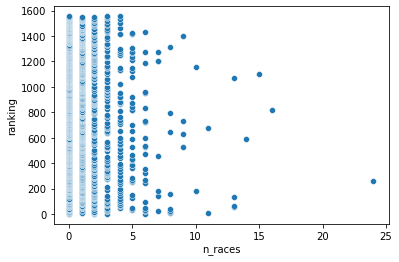

In [8]:
sns.scatterplot(x = data_concat.n_races, y = data_concat.ranking, data = data_concat)

<AxesSubplot:xlabel='n_races', ylabel='relative_ranking'>

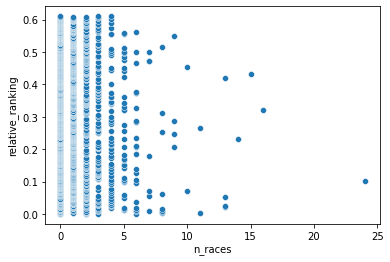

In [38]:
sns.scatterplot(x = data_concat.n_races, y = data_concat.relative_ranking, data = data_concat)

<AxesSubplot:xlabel='n_races', ylabel='time_in_seconds'>

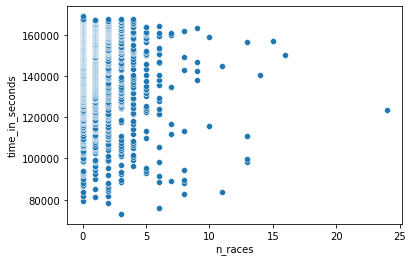

In [39]:
sns.scatterplot(x = data_concat.n_races, y = data_concat.time_in_seconds, data = data_concat)

<AxesSubplot:xlabel='n_races', ylabel='age'>

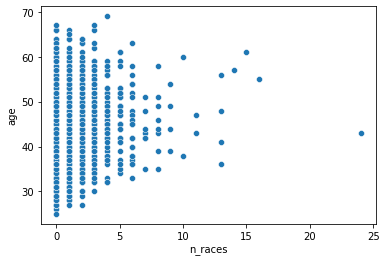

In [14]:
sns.scatterplot(x = data_concat.n_races, y = data_concat.age, data = data_concat)

<AxesSubplot:xlabel='total_elevation', ylabel='ranking'>

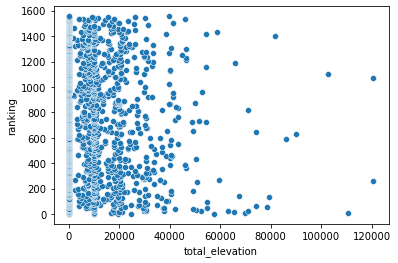

In [15]:
sns.scatterplot(x = data_concat.total_elevation, y = data_concat.ranking, data = data_concat)

<AxesSubplot:xlabel='total_elevation', ylabel='relative_ranking'>

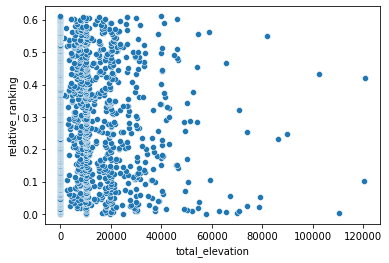

In [40]:
sns.scatterplot(x = data_concat.total_elevation, y = data_concat.relative_ranking, data = data_concat)

<AxesSubplot:xlabel='total_elevation', ylabel='time_in_seconds'>

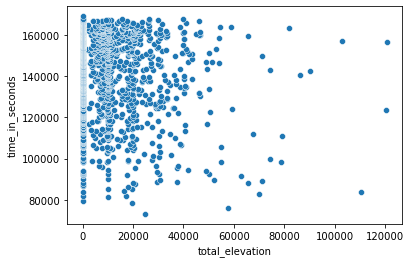

In [41]:
sns.scatterplot(x = data_concat.total_elevation, y = data_concat.time_in_seconds, data = data_concat)

<AxesSubplot:xlabel='total_elevation', ylabel='age'>

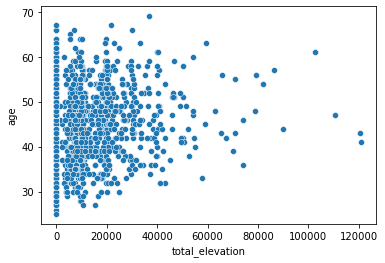

In [16]:
sns.scatterplot(x = data_concat.total_elevation, y = data_concat.age, data = data_concat)

<AxesSubplot:xlabel='total_distance', ylabel='ranking'>

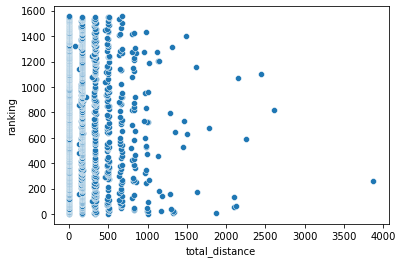

In [17]:
sns.scatterplot(x = data_concat.total_distance, y = data_concat.ranking, data = data_concat)

<AxesSubplot:xlabel='total_distance', ylabel='relative_ranking'>

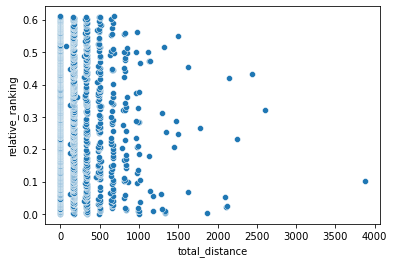

In [42]:
sns.scatterplot(x = data_concat.total_distance, y = data_concat.relative_ranking, data = data_concat)

<AxesSubplot:xlabel='total_distance', ylabel='time_in_seconds'>

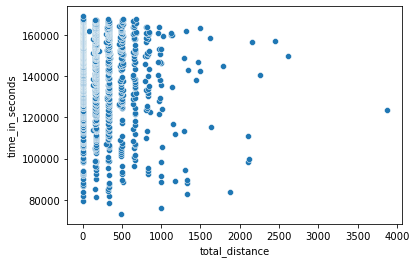

In [43]:
sns.scatterplot(x = data_concat.total_distance, y = data_concat.time_in_seconds, data = data_concat)

<AxesSubplot:xlabel='total_distance', ylabel='age'>

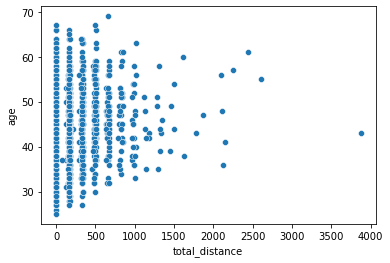

In [18]:
sns.scatterplot(x = data_concat.total_distance, y = data_concat.age, data = data_concat)

<AxesSubplot:xlabel='ranking', ylabel='total_eq_distance'>

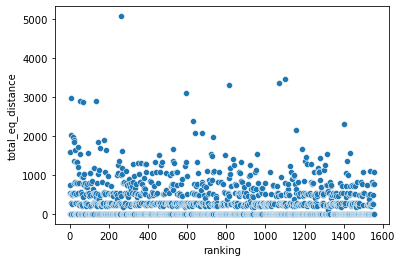

In [21]:
sns.scatterplot(x = data_concat.ranking, y = data_concat.total_eq_distance, data = data_concat)

<AxesSubplot:xlabel='relative_ranking', ylabel='total_eq_distance'>

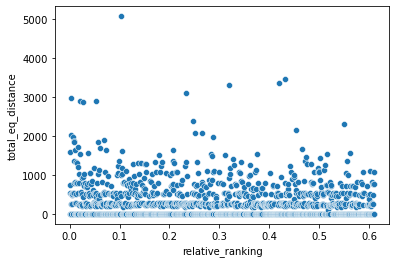

In [44]:
sns.scatterplot(x = data_concat.relative_ranking, y = data_concat.total_eq_distance, data = data_concat)

<AxesSubplot:xlabel='time_in_seconds', ylabel='total_eq_distance'>

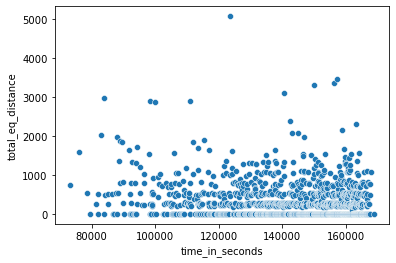

In [45]:
sns.scatterplot(x = data_concat.time_in_seconds, y = data_concat.total_eq_distance, data = data_concat)

<AxesSubplot:xlabel='total_eq_distance', ylabel='age'>

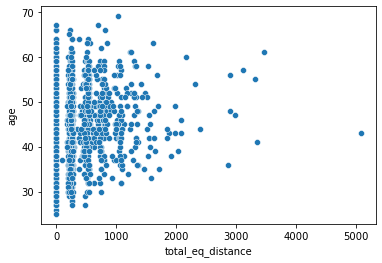

In [20]:
sns.scatterplot(x = data_concat.total_eq_distance, y = data_concat.age, data = data_concat)

In [22]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112176 entries, 0 to 112185
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          112176 non-null  int64         
 1   ranking               112176 non-null  float64       
 2   runner                112176 non-null  object        
 3   time                  112176 non-null  object        
 4   age                   112176 non-null  float64       
 5   gender                112176 non-null  object        
 6   nationality           112176 non-null  object        
 7   time_in_seconds       112176 non-null  float64       
 8   runner_id             112176 non-null  object        
 9   age_course            112176 non-null  float64       
 10  age_range             112176 non-null  category      
 11  speed                 112176 non-null  float64       
 12  equivalent_speed      112176 non-null  float64       
 13 

[Text(0, 0, '219.867'),
 Text(0, 0, '230.757'),
 Text(0, 0, '231.056'),
 Text(0, 0, '220.59'),
 Text(0, 0, '')]

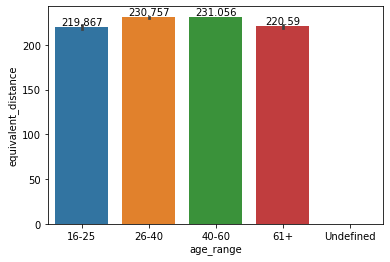

In [29]:
ax = sns.barplot(x = join.age_range, y = join.equivalent_distance, data = join)
ax.bar_label(ax.containers[0])

[Text(0, 0, '232.372'), Text(0, 0, '220.094')]

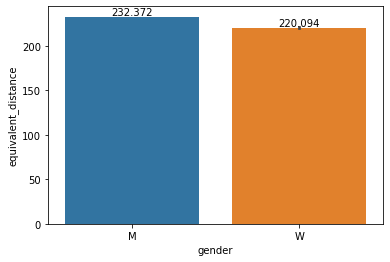

In [30]:
ax = sns.barplot(x = join.gender, y = join.equivalent_distance, data = join)
ax.bar_label(ax.containers[0])

<AxesSubplot:xlabel='equivalent_distance'>

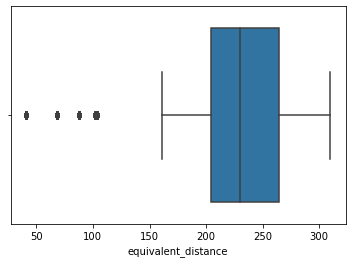

In [31]:
sns.boxplot(x = join.equivalent_distance, data = join)

In [36]:
Q1 = np.percentile(join.equivalent_distance, 25, interpolation = 'midpoint')
Q1

204.4

In [37]:
Q3 = np.percentile(join.equivalent_distance, 75, interpolation = 'midpoint')
Q3

264.2

<AxesSubplot:xlabel='age_range', ylabel='equivalent_distance'>

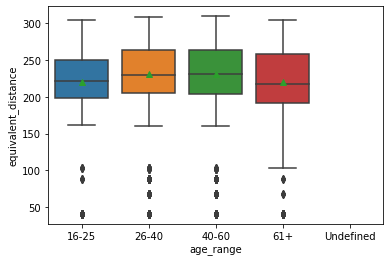

In [34]:
sns.boxplot(x = join.age_range, y = join.equivalent_distance, data = join, showmeans = True)

<AxesSubplot:xlabel='gender', ylabel='equivalent_distance'>

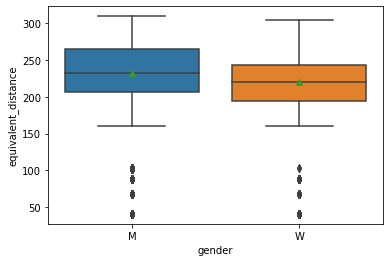

In [35]:
sns.boxplot(x = join.gender, y = join.equivalent_distance, data = join, showmeans = True)